In [1]:
#from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

#tokenizer = AutoTokenizer.from_pretrained("sara-nabhani/google-flan-t5-small-e-snli-generation-label_and_explanation-selected-b48")
#model = AutoModelForSeq2SeqLM.from_pretrained("sara-nabhani/google-flan-t5-small-e-snli-generation-label_and_explanation-selected-b48").cuda()

In [1]:
from datasets import load_dataset

# Load the e-SNLI dataset
dataset = load_dataset("esnli")

#train_dataset = dataset['train']
eval_dataset = dataset['validation']
#test_dataset = dataset['test']

#indices = list(range(0, len(train_dataset), 10))  # Select every 10th index
#train_dataset = train_dataset.select(indices)

#len(train_dataset), len(eval_dataset)#, len(test_dataset)

Reusing dataset esnli (/home/ec2-user/.cache/huggingface/datasets/esnli/plain_text/0.0.2/a160e6a02bbb8d828c738918dafec4e7d298782c334b5109af632fec6d779bbc)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
label_dct = {0: "entailment", 1: "neutral", 2: "contradiction"}
dct = {"entailment": 0, "neutral": 1, "contradiction": 2}

In [3]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")

# Preprocessing function
def preprocess(example):
    # Prepare input and output text
    input_text = f"Premise: {example['premise']} Hypothesis: {example['hypothesis']} What is the relationship? Explain your answer."
    output_text = f"{label_dct[example['label']]}: {example['explanation_1']}. {example['explanation_2']}. {example['explanation_3']}."

    # Tokenize input and output
    input_encoding = tokenizer(input_text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    output_encoding = tokenizer(output_text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    # Create a dictionary to return
    return {
        "input_ids": input_encoding["input_ids"][0],  # Remove batch dimension
        "attention_mask": input_encoding["attention_mask"][0],  # Remove batch dimension
        "labels": output_encoding["input_ids"][0] # Remove batch dimension
    }


# Apply preprocessing
#train_dataset = train_dataset.map(
#    preprocess,
#    remove_columns=['premise', 'hypothesis', 'label', 'explanation_1', 'explanation_2', 'explanation_3'],
#)
eval_dataset = eval_dataset.map(
    preprocess,
    remove_columns=['premise', 'hypothesis', 'label', 'explanation_1', 'explanation_2', 'explanation_3'],
)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/9842 [00:00<?, ?ex/s]

KeyboardInterrupt: 

In [3]:
# Dependency parsing

import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

def dependency_parse(sentence):
    doc = nlp(sentence)
    # Generate the dependency tree structure
    return " ".join([f"<{token.dep_}> {token.text}" for token in doc])

In [4]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")

# Preprocessing function
def preprocess(example):
    # Prepare input and output text
    input_text = f"Premise: example['premise'] Dependency: {dependency_parse(example['premise'])} Hypothesis: example['hypothesis'] Dependency: {dependency_parse(example['hypothesis'])} What is the relationship? Explain your answer."
    output_text = f"{label_dct[example['label']]}: {example['explanation_1']}. {example['explanation_2']}. {example['explanation_3']}."

    # Tokenize input and output
    input_encoding = tokenizer(input_text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    output_encoding = tokenizer(output_text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    # Create a dictionary to return
    return {
        "input_ids": input_encoding["input_ids"][0],  # Remove batch dimension
        "attention_mask": input_encoding["attention_mask"][0],  # Remove batch dimension
        "labels": output_encoding["input_ids"][0] # Remove batch dimension
    }

eval_dataset = eval_dataset.map(
    preprocess,
    remove_columns=['premise', 'hypothesis', 'label', 'explanation_1', 'explanation_2', 'explanation_3'],
)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/9842 [00:00<?, ?ex/s]

In [5]:
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [6]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from datasets import load_metric

# Define the metrics you want to compute
rouge = load_metric("rouge")
bleu = load_metric("bleu")
bertscore = load_metric("bertscore")

In [7]:
full_dct = {}

for checkpoint_num in [1717, 3434, 5151, 6868, 8585, 10302, 12019, 13736, 15453, 17170, 18887, 20604]:

    # Specify the checkpoint path (local or Hugging Face Hub)
    checkpoint_path = "../expt4/flan_t5_esnli/checkpoint-" + str(checkpoint_num)
    
    # Load the tokenizer and model
    tokenizer = T5Tokenizer.from_pretrained(checkpoint_path)
    model = T5ForConditionalGeneration.from_pretrained(checkpoint_path).cuda()
    
    dec_outputs = []
    labels = []
    for i in range(9842):
        en_inputs = eval_dataset[i]
        
        # Get the model's output
        with torch.no_grad():
            outputs = model.generate(en_inputs['input_ids'].cuda().unsqueeze(0), attention_mask=en_inputs['attention_mask'].cuda().unsqueeze(0))
        # Decode the output (convert token IDs back to text)
        decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        dec_outputs.append(decoded_output)
        # Get original labels
        orig = dataset['validation'][i]
        labels.append(f"{label_dct[orig['label']]}: {orig['explanation_1']}. {orig['explanation_2']}. {orig['explanation_3']}.")
    
    exact_preds = []
    exact_labels = []
    for i in range(9842):
        exact_preds.append(dec_outputs[i].split(':')[0])
        exact_labels.append(labels[i].split(':')[0])
    print(checkpoint_num, ":", len(dec_outputs), len(labels), len(exact_preds), len(exact_labels))
    
    accuracy = accuracy_score(exact_labels, exact_preds)
    precision = precision_score(exact_labels, exact_preds, average='weighted')
    recall = recall_score(exact_labels, exact_preds, average='weighted')
    f1 = f1_score(exact_labels, exact_preds, average='weighted')
    rouge_results = rouge.compute(predictions=dec_outputs, references=labels)
    bleu_results = bleu.compute(predictions=[tokenizer.tokenize(dout) for dout in dec_outputs],
                                references=[[tokenizer.tokenize(lbl)] for lbl in labels])
    bertscore_results = bertscore.compute(predictions=dec_outputs, references=labels, lang='en')
    
    tmpdct = {}
    tmpdct['Accuracy'] = accuracy
    tmpdct['Precision'] = precision
    tmpdct['Recall'] = recall
    tmpdct['F1'] = f1
    tmpdct['rouge1'] = rouge_results['rouge1'].mid.fmeasure
    tmpdct['rouge2'] = rouge_results['rouge2'].mid.fmeasure
    tmpdct['rougeL'] = rouge_results['rougeL'].mid.fmeasure
    tmpdct['rougeLsum'] = rouge_results['rougeLsum'].mid.fmeasure
    tmpdct['bleu'] = bleu_results['bleu']
    tmpdct['bertscore'] = np.mean(bertscore_results['f1'])

    full_dct[checkpoint_num] = tmpdct

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


1717 : 9842 9842 9842 9842


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


3434 : 9842 9842 9842 9842


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


5151 : 9842 9842 9842 9842


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


6868 : 9842 9842 9842 9842


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


8585 : 9842 9842 9842 9842


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


10302 : 9842 9842 9842 9842


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


12019 : 9842 9842 9842 9842


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


13736 : 9842 9842 9842 9842


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


15453 : 9842 9842 9842 9842


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


17170 : 9842 9842 9842 9842


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


18887 : 9842 9842 9842 9842


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


20604 : 9842 9842 9842 9842


In [9]:
#import pandas as pd
#df = pd.DataFrame.from_dict(full_dct, orient='index')
#df.to_csv('finetuned_metrics_dep_parse_2.csv')
df

,Accuracy,Precision,Recall,F1,rouge1,rouge2,rougeL,rougeLsum,bleu,bertscore
1717,0.785003,0.791357,0.785003,0.785505,0.305976,0.164003,0.274187,0.274276,0.022325,0.888484
3434,0.817618,0.824828,0.817618,0.819133,0.319454,0.177425,0.286806,0.286852,0.025000,0.890284
5151,0.832554,0.833016,0.832554,0.832282,0.330475,0.185782,0.295853,0.295892,0.028017,0.891558
6868,0.844239,0.844850,0.844239,0.844395,0.342030,0.196331,0.304345,0.304402,0.032545,0.891581
8585,0.843528,0.842901,0.843528,0.842887,0.330851,0.185366,0.295123,0.295233,0.028791,0.891713
10302,0.845763,0.847990,0.845763,0.846361,0.332409,0.186000,0.296334,0.296301,0.027983,0.892246
12019,0.852266,0.854154,0.852266,0.852762,0.330483,0.184768,0.295101,0.295127,0.028651,0.891449
13736,0.851351,0.851642,0.851351,0.851427,0.330287,0.184699,0.295236,0.295243,0.028157,0.891786
15453,0.852266,0.851935,0.852266,0.851993,0.330611,0.185170,0.295392,0.295439,0.027812,0.892709
17170,0.854196,0.855304,0.854196,0.854583,0.333317,0.185642,0.297187,0.297251,0.029121,0.892344


In [9]:
#import pandas as pd
#df = pd.DataFrame.from_dict(full_dct, orient='index')
#df.to_csv('finetuned_metrics_dep_parse.csv')
df

,Accuracy,Precision,Recall,F1,rouge1,rouge2,rougeL,rougeLsum,bleu,bertscore
1717,0.767019,0.780916,0.767019,0.767135,0.313550,0.170333,0.279890,0.279807,0.024491,0.887953
3434,0.821378,0.822594,0.821378,0.821819,0.319514,0.177734,0.286904,0.286757,0.025208,0.890620
5151,0.827779,0.828226,0.827779,0.826749,0.326923,0.182265,0.292942,0.292872,0.027338,0.891194
6868,0.840276,0.839744,0.840276,0.839798,0.339354,0.192991,0.301622,0.301540,0.031543,0.891103
8585,0.843325,0.842824,0.843325,0.842701,0.334203,0.188652,0.297687,0.297604,0.030350,0.891516
10302,0.850640,0.852886,0.850640,0.851195,0.331297,0.185622,0.296071,0.295976,0.027745,0.892516
12019,0.849218,0.848959,0.849218,0.848645,0.329392,0.183935,0.294692,0.294547,0.028410,0.891766
13736,0.850030,0.850412,0.850030,0.850042,0.328779,0.182998,0.293859,0.293751,0.027111,0.892260
15453,0.852875,0.852487,0.852875,0.852558,0.330694,0.184610,0.295569,0.295427,0.028042,0.892244
17170,0.852875,0.853543,0.852875,0.853109,0.333664,0.185779,0.297787,0.297660,0.028886,0.892454


In [11]:
#import pandas as pd
#df = pd.DataFrame.from_dict(full_dct, orient='index')
#df.to_csv('finetuned_metrics.csv')
df

,Accuracy,Precision,Recall,F1,rouge1,rouge2,rougeL,rougeLsum,bleu,bertscore
1717,0.791506,0.798316,0.791506,0.792216,0.315346,0.172856,0.282249,0.282218,0.025040,0.888709
3434,0.823816,0.824766,0.823816,0.824090,0.319376,0.177217,0.286602,0.286584,0.024744,0.890823
5151,0.837127,0.837127,0.837127,0.837037,0.328025,0.183608,0.294088,0.294112,0.027381,0.891864
6868,0.845560,0.845990,0.845560,0.845673,0.340730,0.194530,0.303295,0.303381,0.032375,0.891209
8585,0.847287,0.847026,0.847287,0.847099,0.329061,0.184114,0.294050,0.294056,0.028093,0.891675
10302,0.848202,0.852512,0.848202,0.849256,0.326484,0.180799,0.292041,0.292144,0.025782,0.892846
12019,0.856025,0.858295,0.856025,0.856407,0.328617,0.183529,0.294337,0.294406,0.027895,0.892001
13736,0.851555,0.852861,0.851555,0.851977,0.328562,0.181739,0.293510,0.293569,0.026576,0.892368
15453,0.857041,0.856827,0.857041,0.856883,0.328780,0.182764,0.294289,0.294323,0.026860,0.892717
17170,0.858667,0.859386,0.858667,0.858937,0.333516,0.185581,0.297573,0.297627,0.028458,0.892863


In [10]:
df1 = pd.read_csv('finetuned_metrics.csv')
df2 = pd.read_csv('finetuned_metrics_dep_parse.csv')

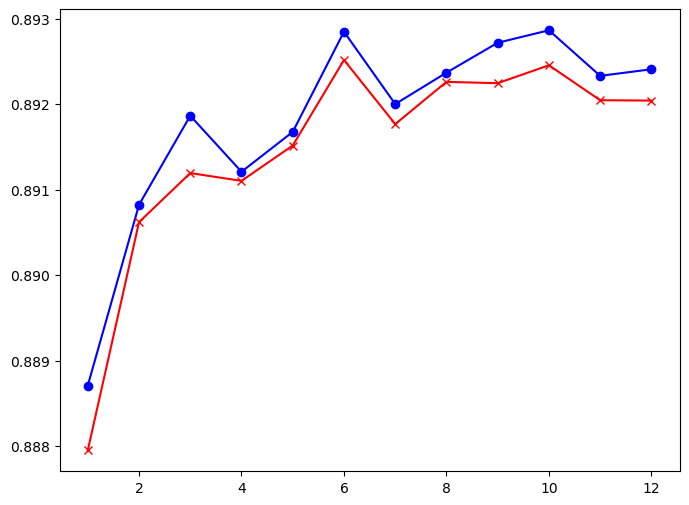

In [23]:
import matplotlib.pyplot as plt
# Create the plot
plt.figure(figsize=(8, 6))

# Plot the columns from both DataFrames
plt.plot(list(range(1,13)), df1['bertscore'], label='orig', color='blue', marker='o')  # Plot df1
plt.plot(list(range(1,13)), df2['bertscore'], label='depparse', color='red', marker='x')   # Plot df2

In [ ]:
Most optimal fine-tuned model selected based on loss:
Accuracy: 0.8378
Precision (Macro): 0.8382
Recall (Macro): 0.8375
F1-score (Macro): 0.8374

My own fine-tuned model epoch 6:
Accuracy: 0.8551
Precision (Macro): 0.8548
Recall (Macro): 0.8548
F1-score (Macro): 0.8547

Directly loaded pretrained:
Accuracy: 0.7040
Precision (Macro): 0.7708
Recall (Macro): 0.7057
F1-score (Macro): 0.7060